In [1]:
import sys
sys.path.append("../../")

from src.statistics.cointegration import find_cointegrated_pairs, analyze_pairs, plot_cointegration_heatmap
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')

DATE_CONFIG = {
   'TRAIN_START': pd.Timestamp('2021-02-02'),
   'TRAIN_END': pd.Timestamp('2024-01-01'),  
   'TEST_END': pd.Timestamp('2025-01-01'),
   'TRADING_DAYS_PER_YEAR': 252  
}

def get_training_period():
    return {
        'start': DATE_CONFIG['TRAIN_START'],
        'end': DATE_CONFIG['TRAIN_END']
    }

def get_test_period():
    return {
        'start': DATE_CONFIG['TRAIN_END'],
        'end': DATE_CONFIG['TEST_END']
    }

def get_training_days():
    years = (DATE_CONFIG['TRAIN_END'] - DATE_CONFIG['TRAIN_START']).days / 365
    return int(years * DATE_CONFIG['TRADING_DAYS_PER_YEAR'])

# Plot settings
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
p_threshold = 0.05
min_pairs = 20

window_shifts = 12
shift_size = 1

std_dev = 2.0
exit_std_dev = 0.5
window_size = 20
hr_window = 25
hr_recalc = 3

base_input_path = "../../data/raw/" 
input_filename = "nasdaq_daily.parquet" 
base_output_path = "../../data/results/" 
output_filename = "CoInt_Bollinger_Sliding.parquet"

In [3]:
def load_and_prepare_data(file_path):
    df = pd.read_parquet(file_path)
    df['date'] = pd.to_datetime(df['date'])
    
    mask = (df['date'] >= DATE_CONFIG['TRAIN_START']) & \
           (df['date'] <= DATE_CONFIG['TEST_END'])
    df = df[mask]
    
    price_matrix = df.pivot(index='date', columns='symbol', values='close')
    
    price_matrix = price_matrix.ffill().bfill()
    
    symbols = price_matrix.columns.tolist()
    
    print(f"Loaded data from {DATE_CONFIG['TRAIN_START']} to {DATE_CONFIG['TEST_END']}")
    print(f"Total symbols: {len(symbols)}")
    print(f"Total trading days: {len(price_matrix)}")
    
    return price_matrix, symbols

In [4]:
input_data_path = f"{base_input_path}{input_filename}"
output_path = f"{base_output_path}{output_filename}"

price_matrix, symbols = load_and_prepare_data(input_data_path)

Loaded data from 2021-02-02 00:00:00 to 2025-01-01 00:00:00
Total symbols: 94
Total trading days: 985


Analyzing pairs: 100%|██████████| 4371/4371 [00:58<00:00, 74.85it/s]



Analysis complete!
Found 244 cointegrated pairs
Total pairs analyzed: 4371


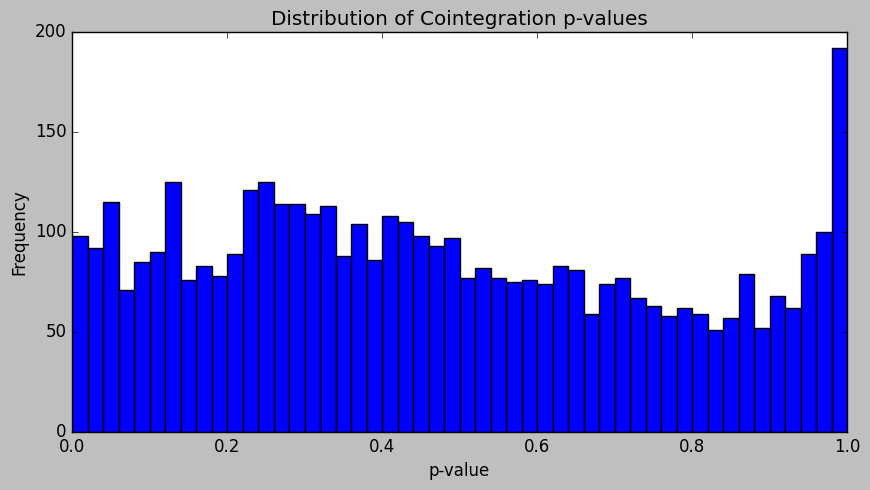

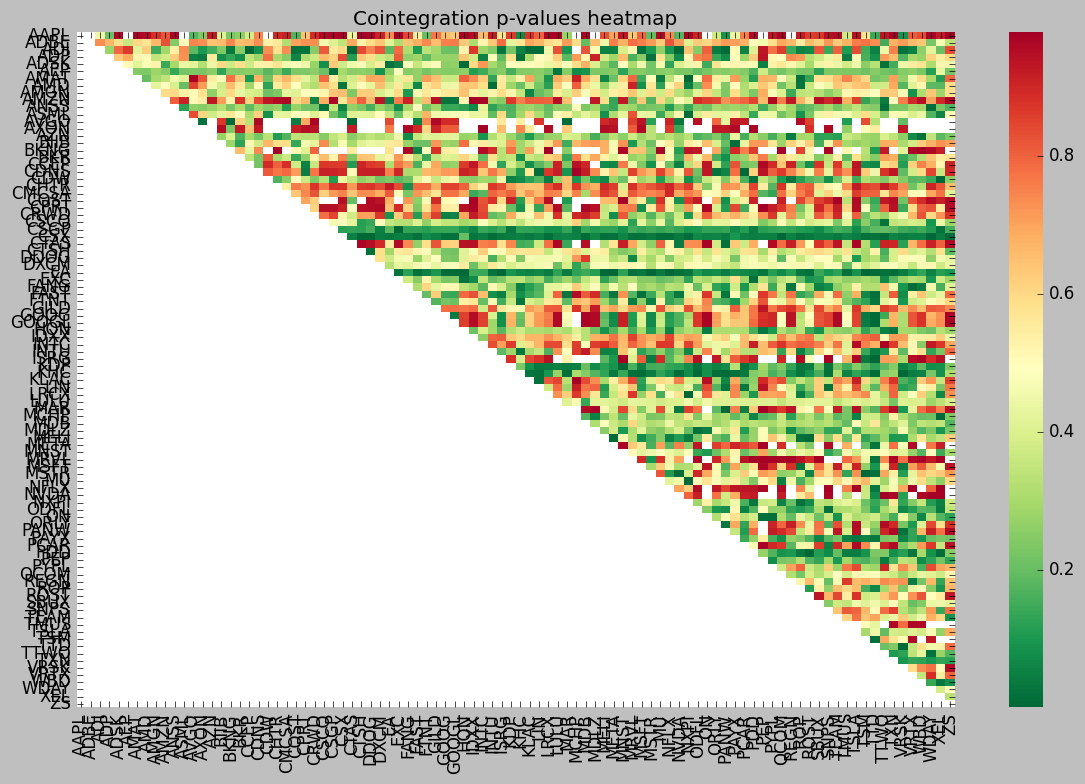

In [5]:
score_matrix, pvalue_matrix, pairs, summary_df = analyze_pairs(
    price_matrix,
    pvalue_threshold=0.05
)

plt.figure(figsize=(10, 5))
plt.hist(summary_df['p_value'], bins=50)
plt.title('Distribution of Cointegration p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.show()

plot_cointegration_heatmap(pvalue_matrix, symbols)

In [6]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

def calculate_spread(data, symbol1, symbol2, start_date=None, end_date=None):
    if start_date:
        mask = (data.index >= start_date) & (data.index <= end_date)
        data = data[mask]
    
    ratios = data[symbol1] / data[symbol2]
    zscore_ratios = zscore(ratios)
    
    return ratios, zscore_ratios

In [7]:
def get_top_pairs(price_matrix, train_start, train_end, symbols):
    train_length = (train_end - train_start).days
    pair_selection_end = train_start + pd.Timedelta(days=int(train_length * 0.7))
    
    selection_mask = (price_matrix.index >= train_start) & (price_matrix.index <= pair_selection_end)
    selection_data = price_matrix[selection_mask]
    
    score_matrix, pvalue_matrix, pairs, summary_df = analyze_pairs(selection_data, pvalue_threshold=p_threshold)
    
    combined_scores = []
    for pair in pairs:
        idx1 = symbols.index(pair[0])
        idx2 = symbols.index(pair[1])
        sum_idx = summary_df[(summary_df['symbol1'] == pair[0]) & (summary_df['symbol2'] == pair[1])].index[0]
        score_value = score_matrix[idx1, idx2]
        p_value = summary_df.loc[sum_idx, 'p_value']
        combined_scores.append({
            'pair': pair,
            'score': -score_value * (1 - p_value)
        })

    sorted_pairs = sorted(combined_scores, key=lambda x: x['score'], reverse=True)
    return [x['pair'] for x in sorted_pairs[:min_pairs]]

In [8]:
def backtest_pairs_rolling(price_matrix, symbols, window_shifts=window_shifts, p_threshold=p_threshold, shift_size=shift_size):
    all_trades = []
    ongoing_trades = []
    
    test_start = DATE_CONFIG['TRAIN_END']
    month_offset = pd.DateOffset(months=shift_size)
    
    print(f"Starting backtest from {test_start} to {DATE_CONFIG['TEST_END']}")
    print(f"Total windows to test: {window_shifts}")
    
    for window_number in range(window_shifts):
        month_start = test_start + window_number * month_offset
        month_end = month_start + month_offset
        train_start = DATE_CONFIG['TRAIN_START'] + window_number * month_offset
        train_end = test_start + window_number * month_offset
        
        print(f"\nWindow {window_number+1}:")
        print(f"Training period: {train_start} to {train_end}")
        print(f"Test period: {month_start} to {month_end}")
        
        updated_ongoing_trades = []
        closed_trades = []
        
        for open_trade in ongoing_trades:
            symbol1, symbol2 = open_trade['symbol1'], open_trade['symbol2']
            
            if symbol1 in price_matrix.columns and symbol2 in price_matrix.columns:
                test_mask = (price_matrix.index >= month_start) & (price_matrix.index < month_end)
                S1_test = price_matrix[symbol1][test_mask]
                S2_test = price_matrix[symbol2][test_mask]
                
                if S1_test.empty or S2_test.empty:
                    updated_ongoing_trades.append(open_trade)
                    continue
                    
                train_data_mask = (price_matrix.index >= train_start) & (price_matrix.index < train_end) 
                S1_train = price_matrix[symbol1][train_data_mask]
                S2_train = price_matrix[symbol2][train_data_mask]
                
                S1_full = pd.concat([S1_train, S1_test])
                S2_full = pd.concat([S2_train, S2_test])
                
                days_since_recalc = 0
                current_hedge_ratio = None
                
                model = sm.OLS(S1_train, S2_train).fit()
                hedge_ratio = model.params[0]
                current_hedge_ratio = hedge_ratio
                
                spread_train = S1_train - (S2_train * hedge_ratio)
                rolling_mean = spread_train.rolling(window=window_size).mean().iloc[-1]
                rolling_std = spread_train.rolling(window=window_size).std().iloc[-1]
                
                closed = False
                for i in range(len(S1_test)):
                    current_date = S1_test.index[i]
                    current_idx = S1_train.shape[0] + i
                    
                    if days_since_recalc >= hr_recalc:
                        if current_idx >= hr_window:
                            hr_data_1 = S1_full.iloc[current_idx-hr_window:current_idx]
                            hr_data_2 = S2_full.iloc[current_idx-hr_window:current_idx]
                            model = sm.OLS(hr_data_1, hr_data_2).fit()
                            current_hedge_ratio = model.params[0]
                            days_since_recalc = 0
                    
                    days_since_recalc += 1
                    
                    current_spread = S1_test.iloc[i] - (S2_test.iloc[i] * current_hedge_ratio)
                    
                    if abs(current_spread - rolling_mean) < (rolling_std * exit_std_dev):
                        for symbol in [symbol1, symbol2]:
                            current_price = S1_test.iloc[i] if symbol == symbol1 else S2_test.iloc[i]
                            closed_trades.append({
                                'trade_id': open_trade['trade_id'],
                                'symbol': symbol,
                                'entry_date': open_trade['entry_date'],
                                'entry_price': open_trade['entry_prices'][symbol]['price'],
                                'exit_date': current_date,
                                'exit_price': current_price,
                                'position_type': open_trade['entry_prices'][symbol]['type'],
                                'paired_symbol': symbol2 if symbol == symbol1 else symbol1,
                                'exit_type': 'target',
                                'window': open_trade['window']
                            })
                        closed = True
                        break
                
                if not closed:
                    updated_ongoing_trades.append(open_trade)
        
        all_trades.extend(closed_trades)
        ongoing_trades = updated_ongoing_trades
        
        top_pairs = get_top_pairs(price_matrix, train_start, train_end, symbols)
        print(f"Found {len(top_pairs)} validated pairs")
        
        trades_this_window = 0
        for pair_idx, (symbol1, symbol2) in enumerate(top_pairs):
            training_mask = (price_matrix.index >= train_start) & (price_matrix.index < train_end)
            test_mask = (price_matrix.index >= month_start) & (price_matrix.index < month_end)
            
            S1_train = price_matrix[symbol1][training_mask]
            S2_train = price_matrix[symbol2][training_mask]
            S1_test = price_matrix[symbol1][test_mask]
            S2_test = price_matrix[symbol2][test_mask]
            
            if S1_test.empty or S2_test.empty:
                continue
            
            S1_full = pd.concat([S1_train, S1_test])
            S2_full = pd.concat([S2_train, S2_test])
            
            model = sm.OLS(S1_train, S2_train).fit()
            hedge_ratio = model.params[0]
            current_hedge_ratio = hedge_ratio
            
            days_since_recalc = 0
            
            spread_train = S1_train - (S2_train * hedge_ratio)
            spread_test = S1_test - (S2_test * hedge_ratio)
            
            rolling_mean = spread_train.rolling(window=window_size).mean().iloc[-1]
            rolling_std = spread_train.rolling(window=window_size).std().iloc[-1]
            
            # Entfernung der position-Variable für das Paar
            # Stattdessen Generierung der nächsten Trade-ID
            next_trade_id = len(all_trades) + len(ongoing_trades) + len(closed_trades)
            
            for i in range(len(spread_test)):
                current_date = spread_test.index[i]
                current_idx = S1_train.shape[0] + i
                
                if days_since_recalc >= hr_recalc:
                    if current_idx >= hr_window:
                        hr_data_1 = S1_full.iloc[current_idx-hr_window:current_idx]
                        hr_data_2 = S2_full.iloc[current_idx-hr_window:current_idx]
                        model = sm.OLS(hr_data_1, hr_data_2).fit()
                        current_hedge_ratio = model.params[0]
                        days_since_recalc = 0
                
                days_since_recalc += 1
                
                current_spread = S1_test.iloc[i] - (S2_test.iloc[i] * current_hedge_ratio)
                
                upper_band = rolling_mean + (rolling_std * std_dev)
                lower_band = rolling_mean - (rolling_std * std_dev)
                
                # Signale für neue Trades unabhängig von bestehenden Positionen prüfen
                if current_spread < lower_band:
                    entry_date = current_date
                    entry_prices = {
                        symbol1: {"price": S1_test.iloc[i], "type": "long"},
                        symbol2: {"price": S2_test.iloc[i], "type": "short"}
                    }
                    
                    ongoing_trades.append({
                        'trade_id': next_trade_id,
                        'symbol1': symbol1,
                        'symbol2': symbol2,
                        'entry_date': entry_date,
                        'entry_prices': entry_prices,
                        'position': 1,
                        'window': window_number + 1
                    })
                    next_trade_id += 1
                    
                elif current_spread > upper_band:
                    entry_date = current_date
                    entry_prices = {
                        symbol1: {"price": S1_test.iloc[i], "type": "short"},
                        symbol2: {"price": S2_test.iloc[i], "type": "long"}
                    }
                    
                    ongoing_trades.append({
                        'trade_id': next_trade_id,
                        'symbol1': symbol1,
                        'symbol2': symbol2,
                        'entry_date': entry_date,
                        'entry_prices': entry_prices,
                        'position': -1,
                        'window': window_number + 1
                    })
                    next_trade_id += 1
                
                # Bestehende Trades für dieses Paar überprüfen und ggf. schließen
                trades_to_close = []
                for idx, trade in enumerate(ongoing_trades):
                    if trade['symbol1'] == symbol1 and trade['symbol2'] == symbol2:
                        if abs(current_spread - rolling_mean) < (rolling_std * exit_std_dev):
                            for symbol in [symbol1, symbol2]:
                                all_trades.append({
                                    'trade_id': trade['trade_id'],
                                    'symbol': symbol,
                                    'entry_date': trade['entry_date'],
                                    'entry_price': trade['entry_prices'][symbol]["price"],
                                    'exit_date': current_date,
                                    'exit_price': S1_test.iloc[i] if symbol == symbol1 else S2_test.iloc[i],
                                    'position_type': trade['entry_prices'][symbol]["type"],
                                    'paired_symbol': symbol2 if symbol == symbol1 else symbol1,
                                    'exit_type': 'target',
                                    'window': trade['window']
                                })
                            
                            trades_to_close.append(idx)
                            trades_this_window += 2
                
                # Schließe Trades von hinten nach vorne (um Indexprobleme zu vermeiden)
                for idx in sorted(trades_to_close, reverse=True):
                    ongoing_trades.pop(idx)
        
        print(f"Closed trades in this window: {len(closed_trades)}")
        print(f"New trades in this window: {trades_this_window}")
        print(f"Currently open trades: {len(ongoing_trades)}")
    
    trades_df = pd.DataFrame(all_trades)
    
    if len(trades_df) > 0:
        trades_df.to_parquet(output_path)
        
        print("\nTrading Summary:")
        print(f"Total trades: {len(trades_df)}")
        print(f"Unique pairs traded: {len(trades_df[['symbol', 'paired_symbol']].drop_duplicates())}")
        print(f"Period: {trades_df['entry_date'].min()} to {trades_df['exit_date'].max()}")
        
        print("\nTrades per window:")
        print(trades_df['window'].value_counts().sort_index())
        
        if 'exit_type' in trades_df.columns:
            print("\nExit types:")
            print(trades_df['exit_type'].value_counts())
    else:
        print("No trades generated!")
        
    return trades_df

In [9]:
trades_df = backtest_pairs_rolling(
    price_matrix=price_matrix,
    symbols=symbols,
    window_shifts=window_shifts
)

Starting backtest from 2024-01-01 00:00:00 to 2025-01-01 00:00:00
Total windows to test: 12

Window 1:
Training period: 2021-02-02 00:00:00 to 2024-01-01 00:00:00
Test period: 2024-01-01 00:00:00 to 2024-02-01 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:27<00:00, 158.53it/s]



Analysis complete!
Found 276 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Closed trades in this window: 0
New trades in this window: 24
Currently open trades: 252

Window 2:
Training period: 2021-03-02 00:00:00 to 2024-02-01 00:00:00
Test period: 2024-02-01 00:00:00 to 2024-03-01 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:27<00:00, 160.19it/s]



Analysis complete!
Found 307 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Closed trades in this window: 316
New trades in this window: 44
Currently open trades: 337

Window 3:
Training period: 2021-04-02 00:00:00 to 2024-03-01 00:00:00
Test period: 2024-03-01 00:00:00 to 2024-04-01 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:26<00:00, 162.37it/s]



Analysis complete!
Found 265 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Closed trades in this window: 126
New trades in this window: 20
Currently open trades: 547

Window 4:
Training period: 2021-05-02 00:00:00 to 2024-04-01 00:00:00
Test period: 2024-04-01 00:00:00 to 2024-05-01 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:27<00:00, 160.47it/s]



Analysis complete!
Found 193 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Closed trades in this window: 658
New trades in this window: 44
Currently open trades: 532

Window 5:
Training period: 2021-06-02 00:00:00 to 2024-05-01 00:00:00
Test period: 2024-05-01 00:00:00 to 2024-06-01 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:27<00:00, 160.48it/s]



Analysis complete!
Found 283 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Closed trades in this window: 506
New trades in this window: 0
Currently open trades: 651

Window 6:
Training period: 2021-07-02 00:00:00 to 2024-06-01 00:00:00
Test period: 2024-06-01 00:00:00 to 2024-07-01 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:27<00:00, 161.83it/s]



Analysis complete!
Found 228 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Closed trades in this window: 504
New trades in this window: 0
Currently open trades: 662

Window 7:
Training period: 2021-08-02 00:00:00 to 2024-07-01 00:00:00
Test period: 2024-07-01 00:00:00 to 2024-08-01 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:27<00:00, 158.82it/s]



Analysis complete!
Found 259 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Closed trades in this window: 648
New trades in this window: 16
Currently open trades: 651

Window 8:
Training period: 2021-09-02 00:00:00 to 2024-08-01 00:00:00
Test period: 2024-08-01 00:00:00 to 2024-09-01 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:27<00:00, 158.69it/s]



Analysis complete!
Found 332 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Closed trades in this window: 380
New trades in this window: 16
Currently open trades: 789

Window 9:
Training period: 2021-10-02 00:00:00 to 2024-09-01 00:00:00
Test period: 2024-09-01 00:00:00 to 2024-10-01 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:27<00:00, 160.68it/s]



Analysis complete!
Found 298 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Closed trades in this window: 630
New trades in this window: 2
Currently open trades: 815

Window 10:
Training period: 2021-11-02 00:00:00 to 2024-10-01 00:00:00
Test period: 2024-10-01 00:00:00 to 2024-11-01 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:26<00:00, 162.01it/s]



Analysis complete!
Found 371 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Closed trades in this window: 808
New trades in this window: 36
Currently open trades: 727

Window 11:
Training period: 2021-12-02 00:00:00 to 2024-11-01 00:00:00
Test period: 2024-11-01 00:00:00 to 2024-12-01 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:25<00:00, 170.02it/s]



Analysis complete!
Found 266 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Closed trades in this window: 768
New trades in this window: 46
Currently open trades: 631

Window 12:
Training period: 2022-01-02 00:00:00 to 2024-12-01 00:00:00
Test period: 2024-12-01 00:00:00 to 2025-01-01 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:25<00:00, 173.45it/s]



Analysis complete!
Found 501 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Closed trades in this window: 764
New trades in this window: 22
Currently open trades: 502

Trading Summary:
Total trades: 6378
Unique pairs traded: 206
Period: 2024-01-02 00:00:00 to 2024-12-27 00:00:00

Trades per window:
window
1     528
2     530
3     566
4     672
5     744
6     526
7     642
8     672
9     578
10    428
11    470
12     22
Name: count, dtype: int64

Exit types:
exit_type
target    6378
Name: count, dtype: int64
